# Analysing Superconductivity Measurements
Group 4: Ryan E, Ryan S, Charlie, Lin

Demonstrator: Emma

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import os

In [2]:
filename = 'data/theta90/Measurement_3_0.50_Field_90_Angle.csv'

df = pd.read_csv(filename, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')
df

,current_A,voltage_uV,time_s
0,0.001374,-1.147232,0.000
1,0.001493,-1.155723,0.046
2,0.001440,-1.157938,0.092
3,0.001470,-1.177527,0.139
4,0.001357,-1.168936,0.185
...,...,...,...
1184,50.575273,46.828987,76.567
1185,50.605946,47.131116,76.612
1186,50.637175,47.440590,76.659
1187,50.743026,47.754784,76.706


Extracting metadata by reading the first few liens of the .csv file - temperature, angle and magnetic field. 

### NOTE - the `angle` embedded in the .csv is 0 degrees as we forgot to set it on labview. However, the angle in the filename is correct! 

The code below extracts temperature, angle and field from the data in the .csv. Later on I extract the angle and field from the filename instead.

In [3]:
# Step 1: Open the file and read lines manually
f = open(filename)
text = f.readlines()

# Step 2: Extract metadata, ignoring blank lines
def extract_value(lines, key):
    """Helper function to extract the value for a given key."""
    for line in lines:
        if key in line:
            return float(line.split('\t')[1].strip())  # Extract the value after tab

temperature = extract_value(text, "Temperature (K)")
angle = extract_value(text, "Angle (deg.)")
field = extract_value(text, "field / T")
print(f'T={temperature}, Angle={angle}, Field={field}')

T=77.0, Angle=0.0, Field=0.5


Quick Plot of Voltage (uV) vs Current (A): 

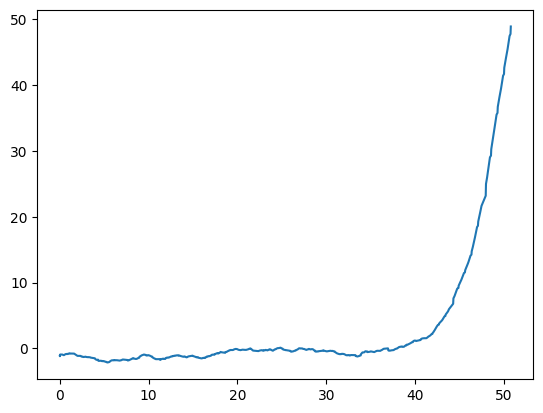

In [4]:
plt.plot(df['current_A'],df['voltage_uV'])

To find the critical current $I_C$, we read off the graph where we have an electric field E=100 uV/m. The distance between our voltage points on the sample is 0.8 cm. Therefore the voltage where this occurs is E*m = 100 uV/m * 0.008 m = 0.8 uV.

After speaking to demonstrator, we chose an electric field of 2000 uV/m instead which corresponds to a voltage V = 20 uV.

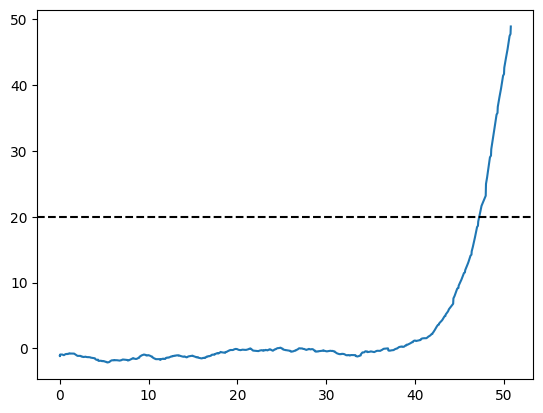

In [5]:
fig, ax = plt.subplots()
ax.plot(df['current_A'],df['voltage_uV'])
ax.axhline(20, c="black", ls="--")

Finding the row with voltage closest to 20 uV:

In [6]:
(df['voltage_uV'] - 20).abs().idxmin()

1107

So the current at this voltage is:

In [7]:
I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

Now we have the code, we will now iterate through all the data files. Here I have extracted angle and field from the filename. This function uses a directory as an argument and returns a pandas dataframe with columsn `angle`, `field`, and `I_c`. In my case, I iterate through .csv files in `data/theta0/`, `/data/theta45/`, etc.

[]

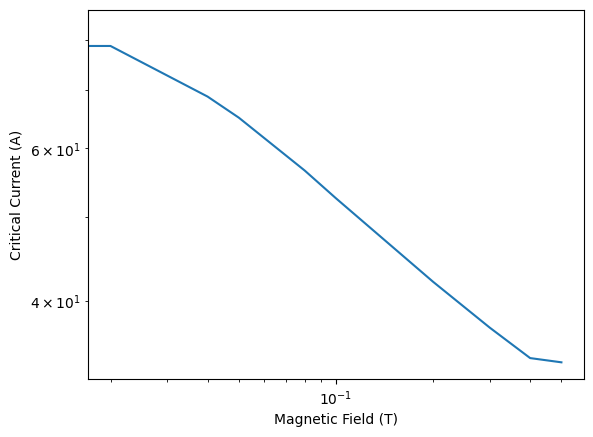

In [8]:
# Iterate through files in specified directory #
def Analyse_directory(directory):
    rows = []
    for filename in os.listdir(directory):
        try:
            file_string = os.path.join(directory, filename).replace('\\','/')   # example string: 'data/P1_B1_Idefault_Ndefault.mat'
            df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')

        except:
            print(f"Error: Cannot load {file_string}.")

        # Extract metadata from filename
        filename_split = file_string.split("_")
        angle = float(filename_split[-2])
        field = float(filename_split[-4])

        # Find Critical Current (current value at voltage closest to 20 uV)
        I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

        # Append to our whole dataset
        row = [angle,field,I_c]
        rows.append(row)

    columns=['angle','field','I_c']
    df_Ic = pd.DataFrame(rows, columns=columns)
    return df_Ic

df_Ic_0 = Analyse_directory('data/theta0/')

fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'])
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
plt.loglog()

In [9]:
df_Ic_0 = Analyse_directory('data/theta0/')
df_Ic_45 = Analyse_directory('data/theta45/')
df_Ic_90 = Analyse_directory('data/theta90/')
df_Ic_135 = Analyse_directory('data/theta135/')


[]

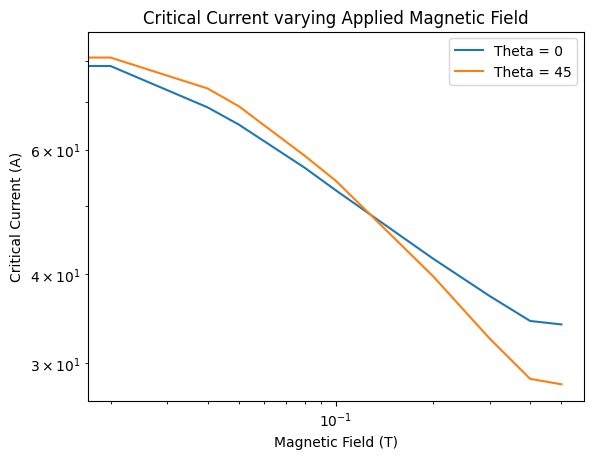

In [10]:
fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'], label="Theta = 0")
ax.plot(df_Ic_45['field'], df_Ic_45['I_c'], label="Theta = 45")
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
ax.set_title("Critical Current varying Applied Magnetic Field")
plt.legend()
plt.loglog()


[]

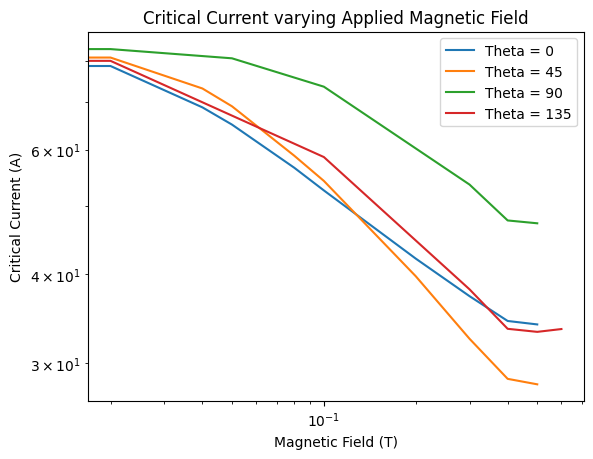

In [11]:
fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'], label="Theta = 0")
ax.plot(df_Ic_45['field'], df_Ic_45['I_c'], label="Theta = 45")
ax.plot(df_Ic_90['field'], df_Ic_90['I_c'], label="Theta = 90")
ax.plot(df_Ic_135['field'], df_Ic_135['I_c'], label="Theta = 135")
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
ax.set_title("Critical Current varying Applied Magnetic Field")
# plt.xscale('log')
plt.legend()
plt.loglog()


Instead of finding the critical current at E=2000 uV/m, we can curve fit the data to:

$E=E_C \left(\frac{I}{I_C}\right)^n$

multiply by distance between voltage probes on both sides:

$V=V_C \left(\frac{I}{I_C}\right)^n$

Because there's a linear increase before the critical current, we will first linear fit to the first half of the data. We subtract this linear fit from the data, and then fit to the power law above. 


Let's try fitting to one dataset first:

Measurement_1_0.50_Field_0_Angle.csv


[]

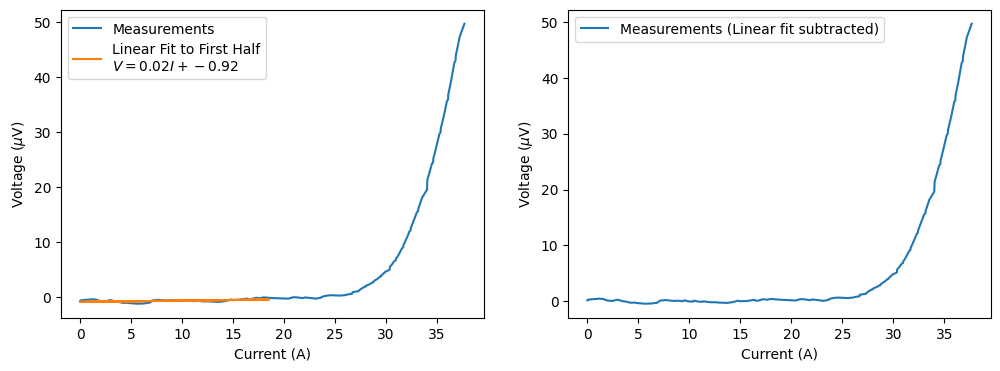

In [91]:
filename = 'data/theta0/Measurement_1_0.50_Field_0_Angle.csv'
df = pd.read_csv(filename, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')

# Linear Fitting to half the data
half = round(len(df)*0.5) # Finds the row index halfway through the data (usually around I = 18A)
slope, intercept = linregress(df[:half]['current_A'], df[:half]['voltage_uV'])[0:2] 
linear_yvalues = df['current_A']*slope + intercept # The y-values of the linear fit extrapolated to the whole range of data that we will subtract from our data. 

xdata = df['current_A']
ydata = df['voltage_uV']
ydata_clean = df['voltage_uV'] - linear_yvalues

print(filename.split('/')[-1])
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(xdata, ydata, label='Measurements')
ax[0].plot(xdata[:half], linear_yvalues[:half], label=f'Linear Fit to First Half\n$V = {slope:.2f}I + {intercept:.2f}$')
ax[0].set_xlabel('Current (A)')
ax[0].set_ylabel('Voltage ($\\mu$V)')

ax[1].plot(xdata, ydata_clean, label='Measurements (Linear fit subtracted)')
ax[1].set_xlabel('Current (A)')
ax[1].set_ylabel('Voltage ($\\mu$V)')

ax[0].legend()
ax[1].legend()
plt.plot()

Now we have a corrected baseline, we can fit the power law to the cleaned data. 

$V = V_c \left( \frac{I}{I_c} \right)^n$

The distance between voltage taps was measured to be ~1.4 cm. To find the critical current we can use the electric field criterion -> the current when the electrical field uses a certain value. A value of 100 μV/m is commonly used [(source for this)](https://link.springer.com/chapter/10.1007/978-3-540-44515-9_5#:~:text=The%20most%20general%20method%20for,also%20called%20the%20resistive%20method.). Using a distance of 1.4cm, we can change the y-axis of our data to an electric field. 

In [92]:
E_c = 100

def fit_function(x, *params):
    """
    This function defines the mathmatecal function we want to fit the data to. In our case this is E = E_c * (I/I_c)^n.
    Parameters are I_c and n. E_c is set to a constant we want. 
    """
    I_c, n = params 
    return E_c * (x/I_c)**n

def power_fitting(xdata, ydata):
    """
    Fits the function defined in fit_function().

    arguments:
    ----------
    - xdata 
    - ydata
    
    returns:
    --------
    - I_c - critical current
    - n - exponent of (I/I_c)^n
    - popt - all parameters from scipy.optimize.curve_fit
    """

    # Initial Guesses
    guess = [30, 20]

    try:
        popt, pcov = curve_fit(fit_function, xdata, ydata, p0=guess, ) # can add maxfev=5000
    except RuntimeError as e:
        print('Fit did not converge:', e)
    # Print Parameters
    for i in range(len(popt)):
        print(f'Parameter {i}: {popt[i]:.5f}') # ± {np.sqrt(pcov[i][i]):.5f}

    I_c = popt[0]
    n = popt[1]

    return I_c, n, popt

Parameter 0: 26.03451
Parameter 1: 9.96894
Critical Current = 26.035


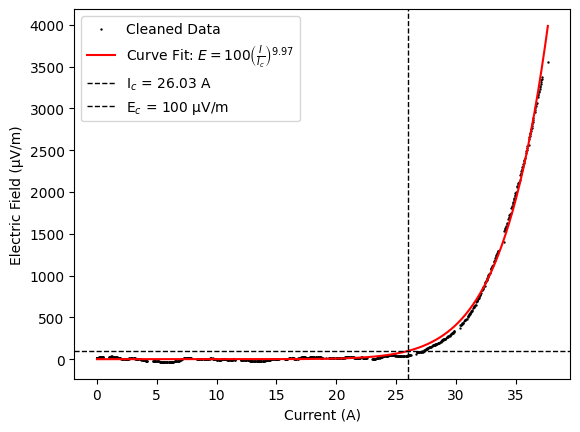

In [93]:
# Fitting the power law
ydata_clean = (df['voltage_uV'] - linear_yvalues)/(1.4E-2) # Converting from voltage to electric field (1.4 cm voltage tap distance)
x_extended = np.linspace(df['current_A'].min(), df['current_A'].max(), 500)
I_c, n, popt = power_fitting(xdata, ydata_clean)
y_fit = fit_function(x_extended, *popt)

# Plotting
fig, ax = plt.subplots()
ax.scatter(xdata, ydata_clean, label='Cleaned Data', s=0.5, c='black')
ax.plot(x_extended, y_fit, c='red', label=f'Curve Fit: $E = {E_c} \\left(\\frac{{I}}{{I_c}}\\right)^{{{n:.2f}}}$')
ax.axvline(I_c, ls='--', label=f'I$_c$ = {I_c:.2f} A', lw=1, c='black')
ax.axhline(E_c, ls='--', label=f'E$_c$ = {E_c} μV/m', lw=1, c='black')
ax.set_xlabel('Current (A)')
ax.set_ylabel('Electric Field (μV/m)')
plt.legend()
plt.plot()

print(f'Critical Current = {I_c:.3f}')